In [1]:
import _fn
import matplotlib.pyplot as plt
import numpy as np



# **Phantom objects generation**

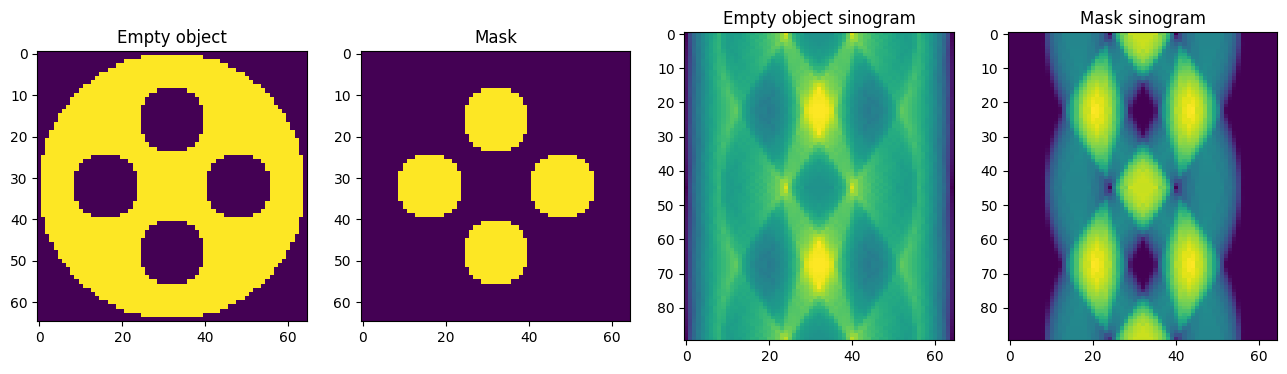

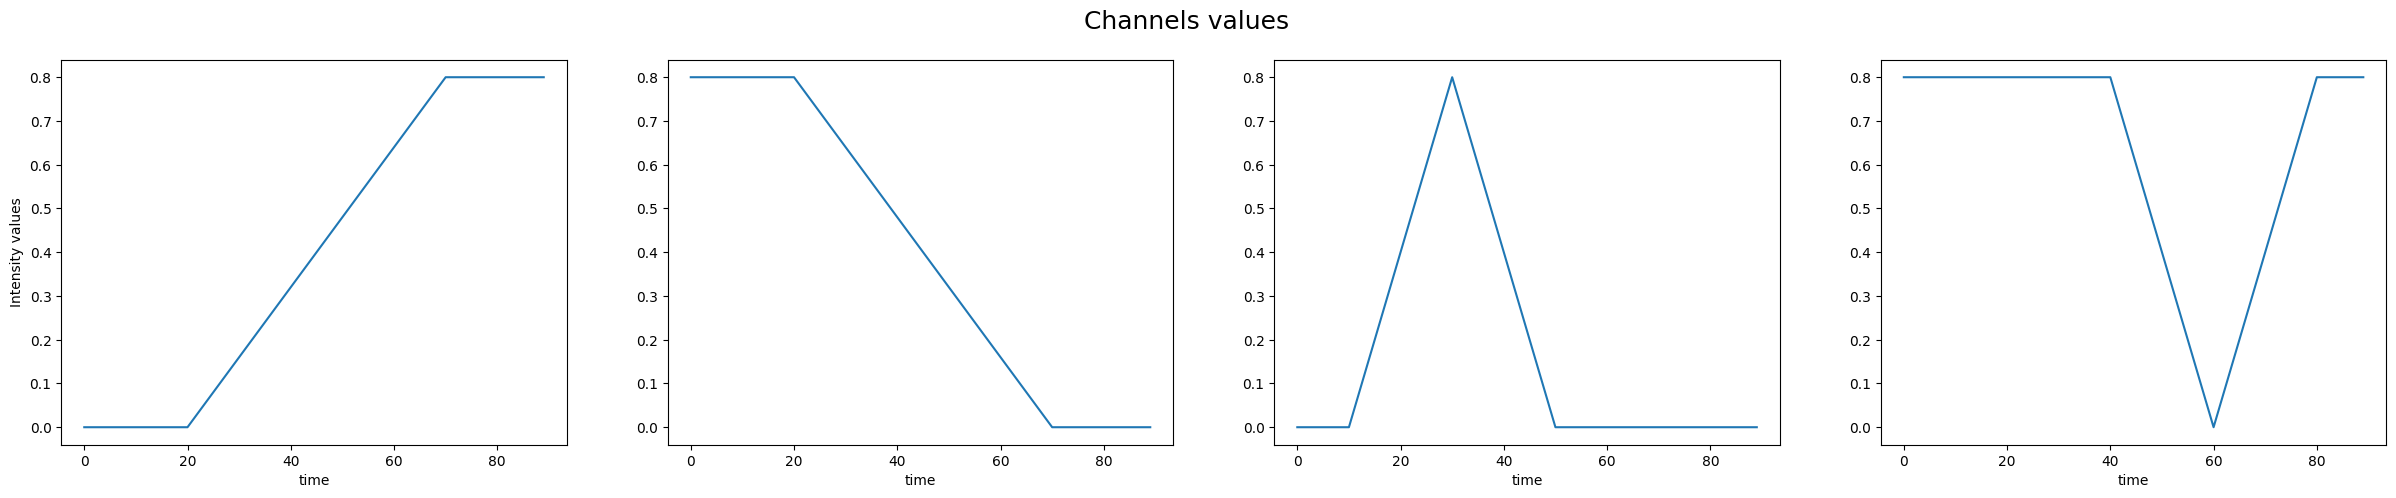

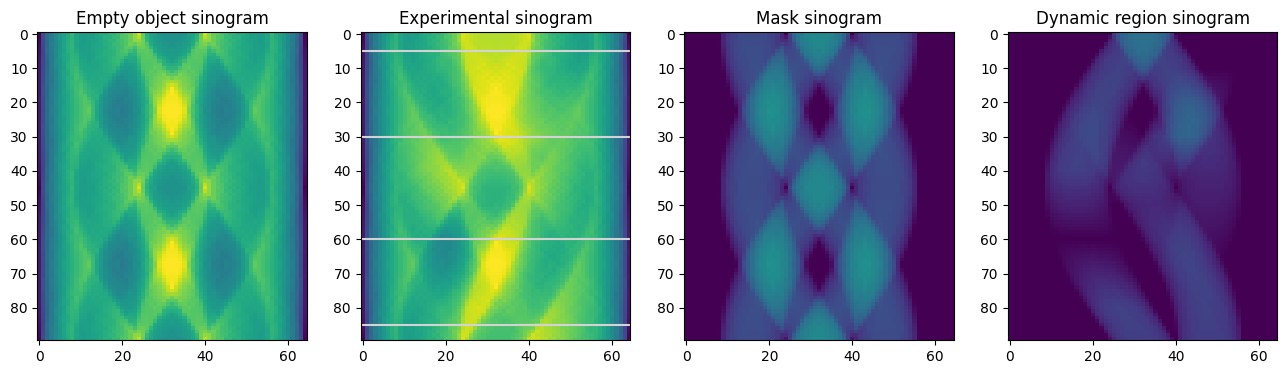

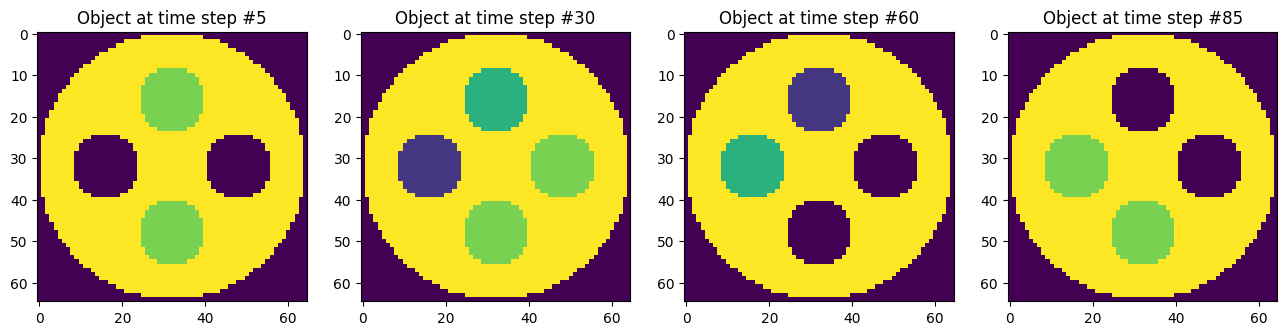

empty_object shape: (65, 65)
empty_sinogram shape: (90, 65)
experimental_objects shape: (90, 65, 65)
experimental_sinogram shape: (90, 65)
experimental_sinograms shape: (90, 90, 65)


In [2]:
number_of_time_points = 90

phantom_data = _fn.create_phantom_objects(number_of_time_points, 4)
# phantom_data = _fn.create_phantom_objects(number_of_time_points, 4, _ch_type='sparse')
# phantom_data = _fn.create_phantom_objects(number_of_time_points, 4, _ch_type='tight')
# phantom_data = _fn.create_phantom_objects(number_of_time_points, 8)

(empty_object,
 mask_object,

 empty_sinogram,
 mask_sinogram,

 channels_data,

 experimental_objects,

 experimental_sinogram,
 experimental_sinograms) = phantom_data

_channels_pixels, _, _ = channels_data

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(empty_object)
axes[0].set_title('Empty object')
axes[1].imshow(mask_object)
axes[1].set_title('Mask')
axes[2].imshow(empty_sinogram, aspect='auto')
axes[2].set_title('Empty object sinogram')
axes[3].imshow(mask_sinogram, aspect='auto')
axes[3].set_title('Mask sinogram')
plt.show()

_fn.plot_channels_area_values(_channels_pixels, experimental_objects)

times = np.floor(np.array([10, 60, 120, 170]) * number_of_time_points / 180).astype(int)
vmax = np.max(empty_sinogram)

dynamic_region_sinogram = experimental_sinogram - empty_sinogram

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(empty_sinogram, vmax=vmax, aspect='auto')
axes[0].set_title('Empty object sinogram')
axes[1].imshow(experimental_sinogram, vmax=vmax, aspect='auto')
for time_point in times:
    axes[1].axhline(time_point, color='lightgray')
axes[1].set_title('Experimental sinogram')
axes[2].imshow(mask_sinogram, vmax=vmax, aspect='auto')
axes[2].set_title('Mask sinogram')
axes[3].imshow(dynamic_region_sinogram, vmax=vmax, aspect='auto')
axes[3].set_title('Dynamic region sinogram')
plt.show()

fig, axes = plt.subplots(1, len(times), figsize=(4 * len(times), 4))
for index, axis in enumerate(axes):
    axis.imshow(experimental_objects[times[index]], vmin=0, vmax=1)
    axis.set_title(f'Object at time step #{times[index]}')
plt.show()

print(f'empty_object shape: {empty_object.shape}')
print(f'empty_sinogram shape: {empty_sinogram.shape}')
print(f'experimental_objects shape: {experimental_objects.shape}')
print(f'experimental_sinogram shape: {experimental_sinogram.shape}')
print(f'experimental_sinograms shape: {experimental_sinograms.shape}')

# **Algorythm implementation**

### 1. Create initial sinograms

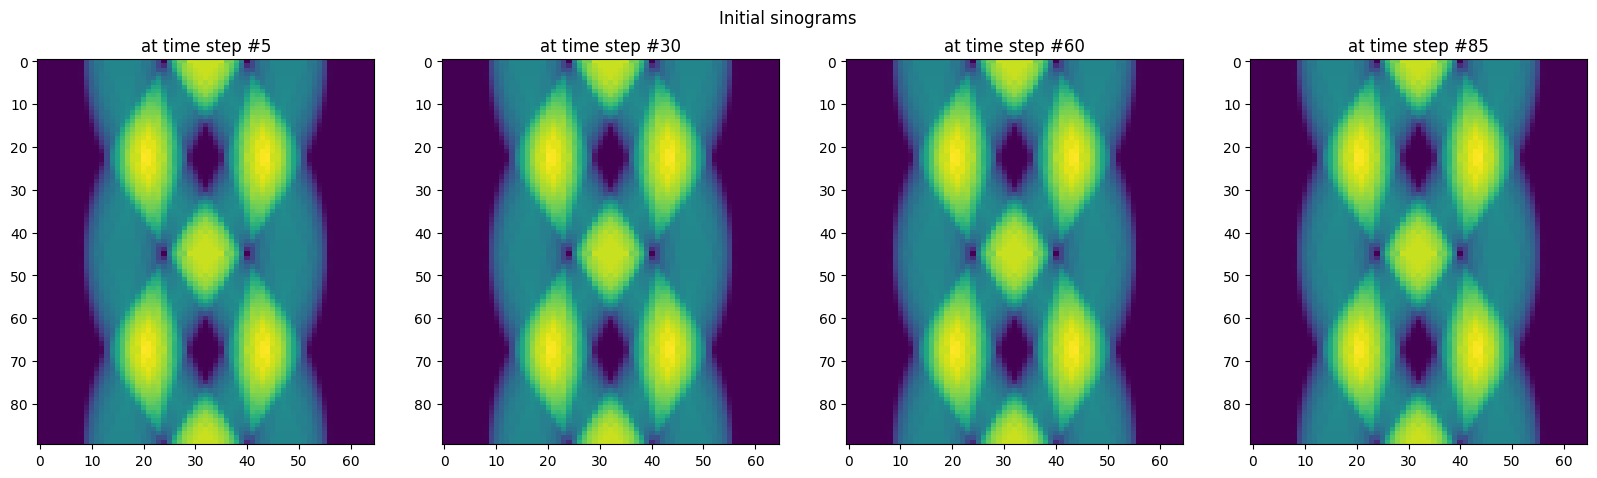

(90, 90, 65)


In [3]:
sino_array_shape = (number_of_time_points, *mask_sinogram.shape)
initial_sinograms = np.tile(mask_sinogram.flatten(), number_of_time_points).reshape(sino_array_shape)

fig, axes = plt.subplots(1, len(times), figsize=(5 * len(times), 5))
plt.suptitle('Initial sinograms')
for index, axis in enumerate(axes):
    axis.imshow(initial_sinograms[times[index]], aspect='auto')
    axis.set_title(f'at time step #{times[index]}')
plt.show()

print(initial_sinograms.shape)

### 2. Insert experimental values into sinograms

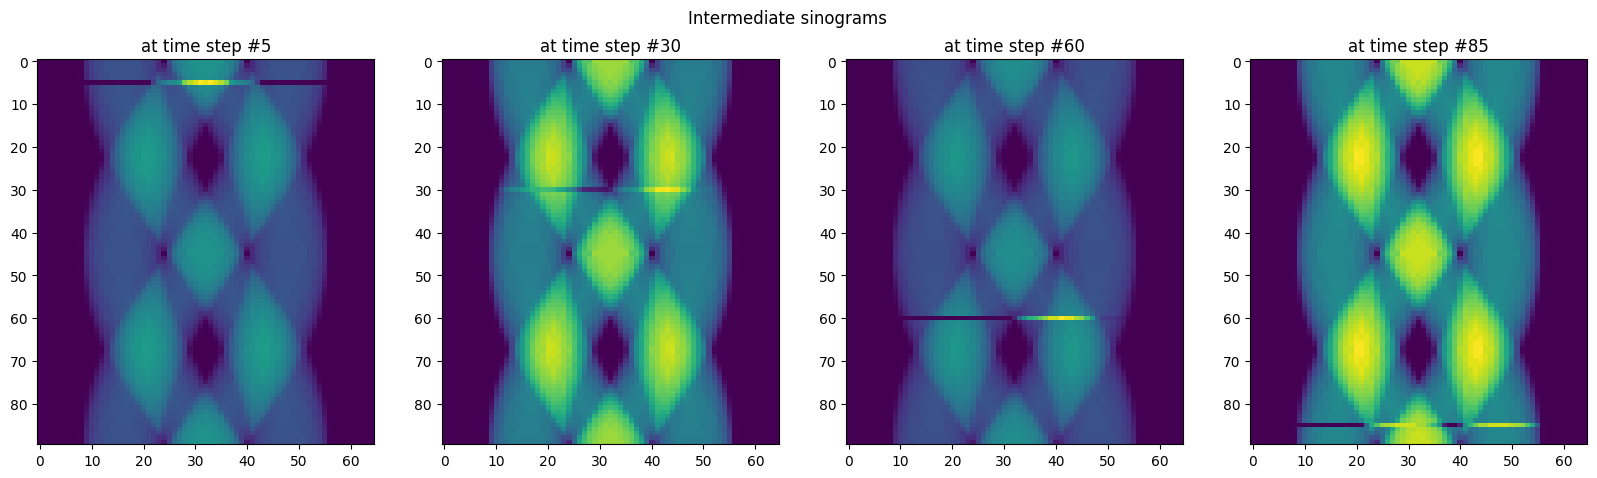

(90, 90, 65)


In [4]:
i_sinograms = _fn.insert_exp_values(initial_sinograms, dynamic_region_sinogram)
i_sinograms = _fn.normalize_sinograms(i_sinograms, dynamic_region_sinogram)

fig, axes = plt.subplots(1, len(times), figsize=(5 * len(times), 5))
plt.suptitle('Intermediate sinograms')
for index, axis in enumerate(axes):
    axis.imshow(i_sinograms[times[index]], aspect='auto')
    axis.set_title(f'at time step #{times[index]}')
plt.show()

print(i_sinograms.shape)

### 3. Make exponential smoothing at projections domain

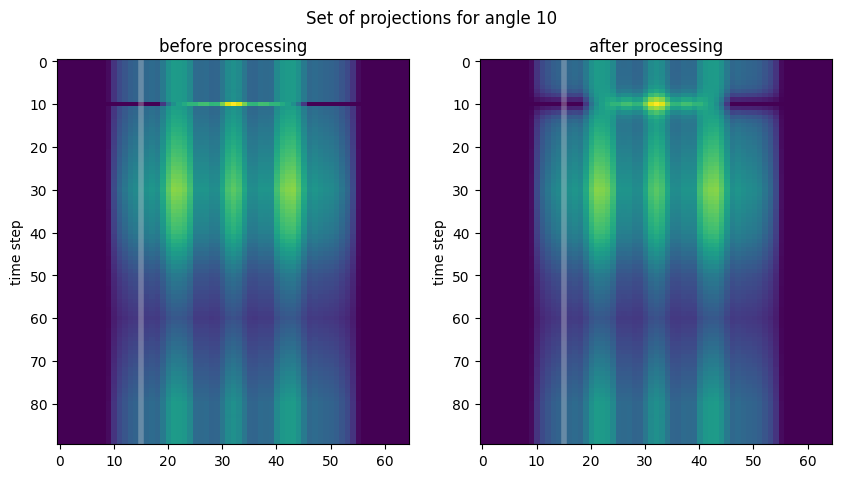

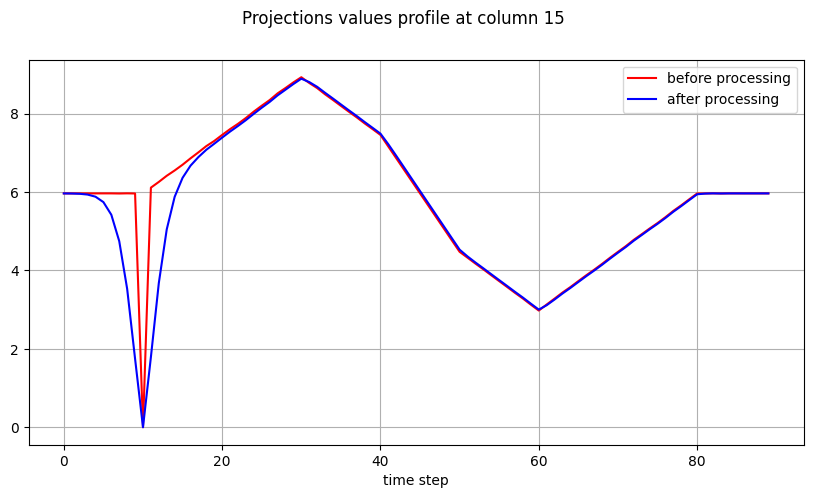

In [5]:
angle_to_show = 10
column_to_show = 15

i_sino = np.copy(i_sinograms[:, angle_to_show, :])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f'Set of projections for angle {angle_to_show}')

axes[0].imshow(i_sino, aspect='auto')
axes[0].axvline(column_to_show, linewidth=4, color=u'#dddddd50')
axes[0].set_title('before processing')
axes[0].set_ylabel('time step')

power = 0.5
i_sinograms = _fn.extrapolate_exp_sino_data(number_of_time_points, i_sinograms, power=power)

axes[1].imshow(i_sinograms[:, angle_to_show, :], aspect='auto')
axes[1].axvline(column_to_show, linewidth=4, color=u'#dddddd50')
axes[1].set_title('after processing')
axes[1].set_ylabel('time step')

plt.show()

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
plt.suptitle(f'Projections values profile at column {column_to_show}')
axes.plot(i_sino[:, column_to_show], c='red', label='before processing')
axes.plot(i_sinograms[:, angle_to_show, column_to_show], c='blue', label='after processing')
axes.set_xlabel('time step')
plt.grid()
plt.legend()
plt.show()

### 4. Calculate intermediate objects

(90, 65, 65)


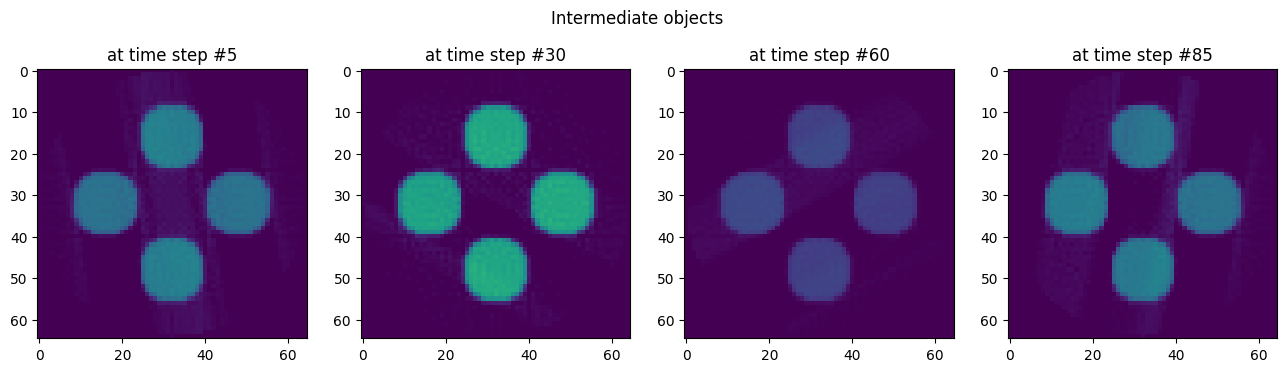

In [6]:
i_objects = _fn.calc_intermediate_objects(i_sinograms, mask_object, number_of_time_points)
print(i_objects.shape)

fig, axes = plt.subplots(1, len(times), figsize=(4 * len(times), 4))
plt.suptitle('Intermediate objects')
for index, axis in enumerate(axes):
    axis.imshow(i_objects[times[index]], vmin=0, vmax=1)
    axis.set_title(f'at time step #{times[index]}')
plt.show()

### 5-6. Apply mask to objects and equalize channels values

(90, 65, 65)


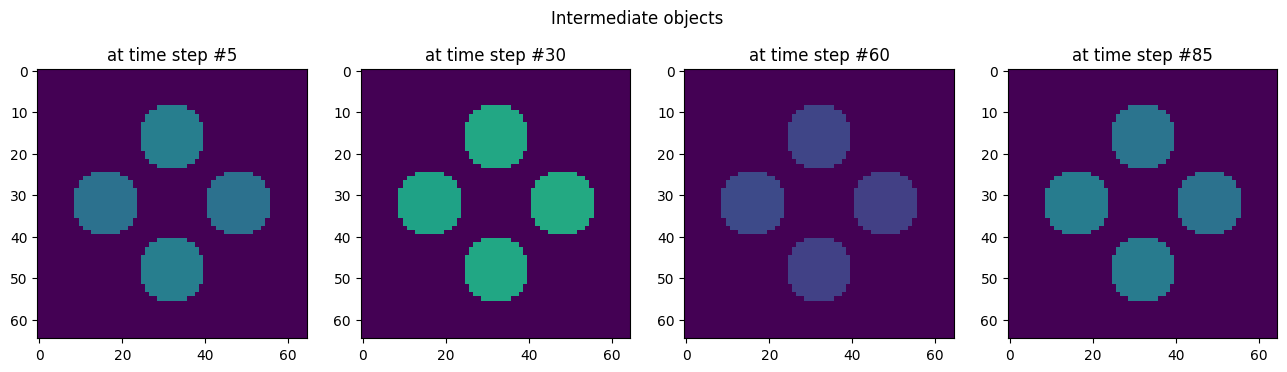

In [7]:
i_objects = _fn.norm_intermediate_objects(i_objects, mask_object, _channels_pixels)
print(i_objects.shape)

fig, axes = plt.subplots(1, len(times), figsize=(4 * len(times), 4))
plt.suptitle('Intermediate objects')
for index, axis in enumerate(axes):
    axis.imshow(i_objects[times[index]], vmin=0, vmax=1)
    axis.set_title(f'at time step #{times[index]}')
plt.show()

### 7. Calculate intermediate sinograms

(90, 90, 65)


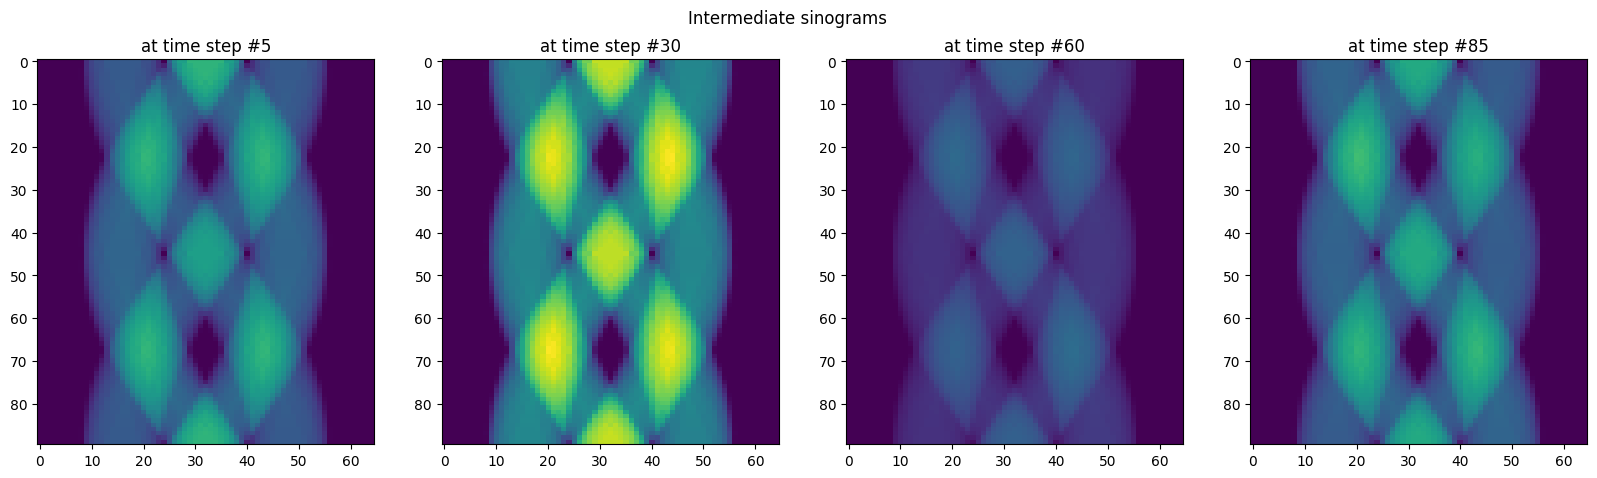

(90, 90, 65)


In [8]:
i_sinograms = _fn.get_iteration_sinograms(i_objects, number_of_time_points)
print(i_sinograms.shape)

vmax = np.max(i_sinograms)
vmin = np.min(i_sinograms)

fig, axes = plt.subplots(1, len(times), figsize=(5 * len(times), 5))
plt.suptitle('Intermediate sinograms')
for index, axis in enumerate(axes):
    axis.imshow(i_sinograms[times[index]], aspect='auto', vmax=vmax, vmin=vmin)
    axis.set_title(f'at time step #{times[index]}')
plt.show()

print(i_sinograms.shape)

### 8. Check RRMSE and go to Step 2 or exit

# **Test different algorithms with different objects**

### New algorithm with 4-channel "regular" object, iteration_stop_diff = 0.001

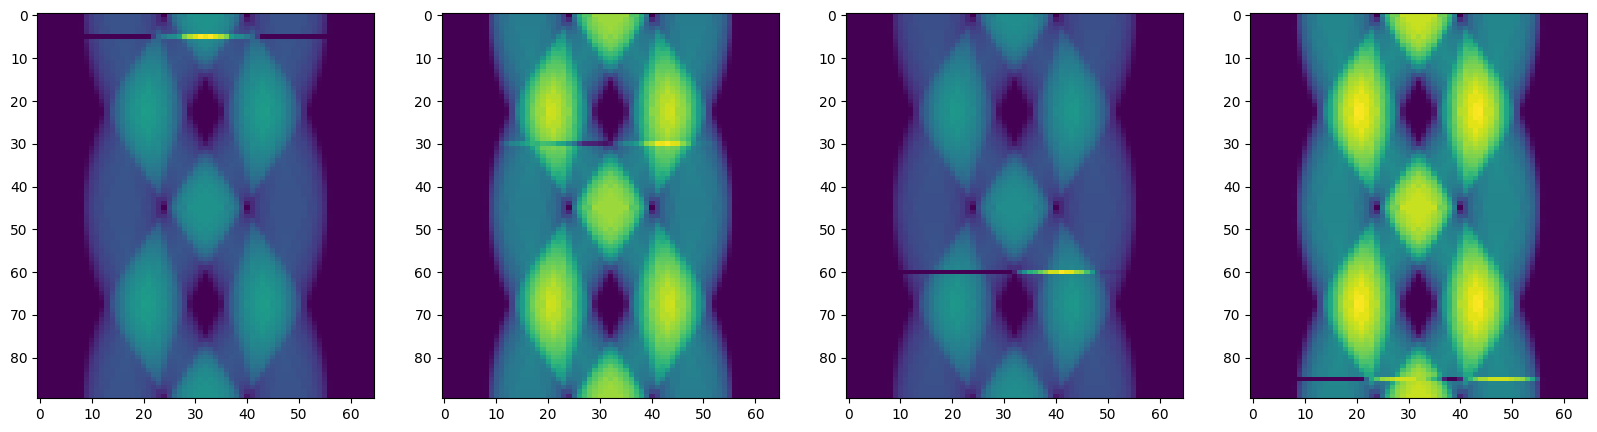

i_sinograms shape: (90, 90, 65)
iteration: 0,	 sino rsme: 0.06842687159540543,	 objects rsme: 0.16011771779090825


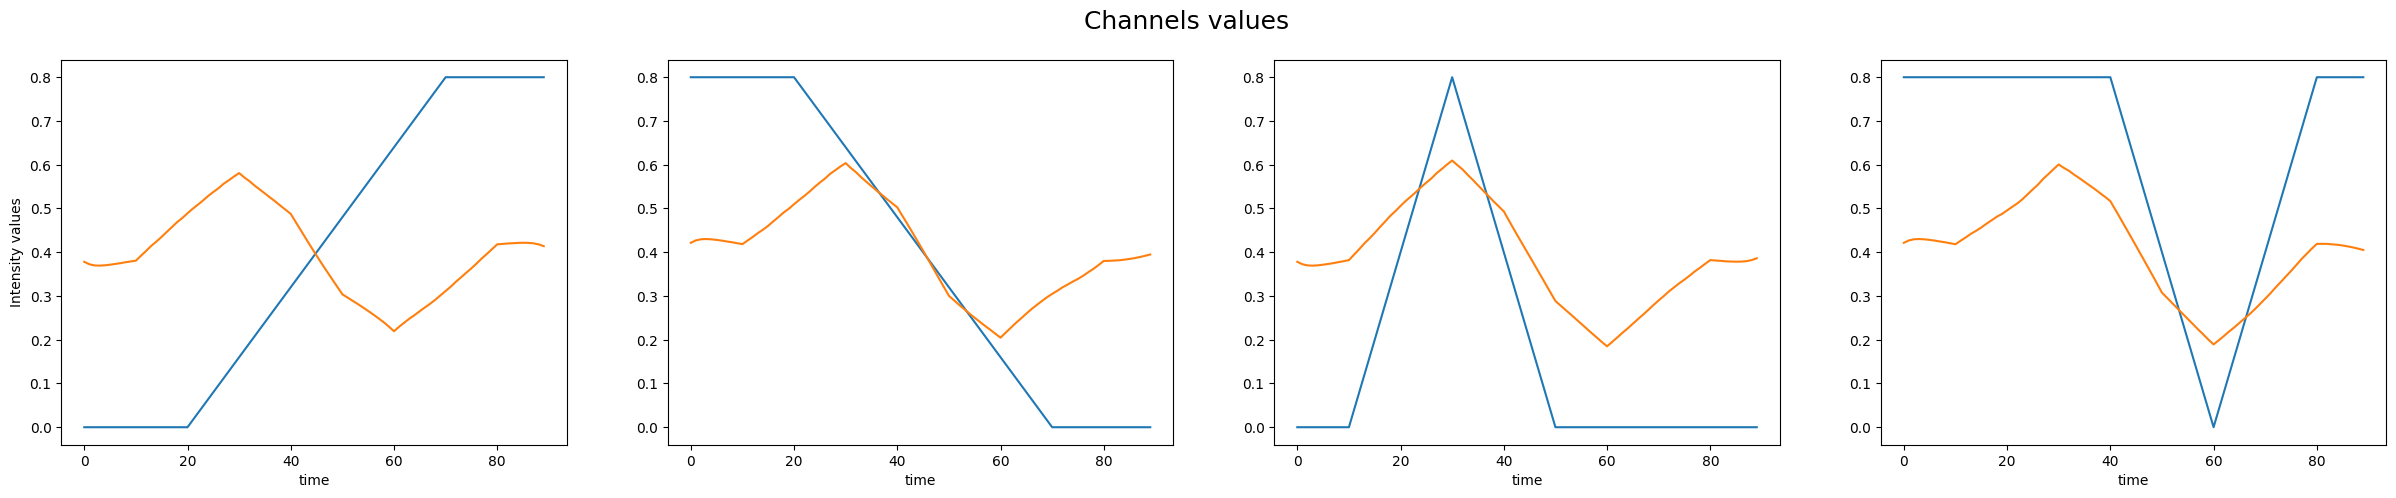

iteration: 10,	 sino rsme: 0.04033414520583973,	 objects rsme: 0.11219439492178979


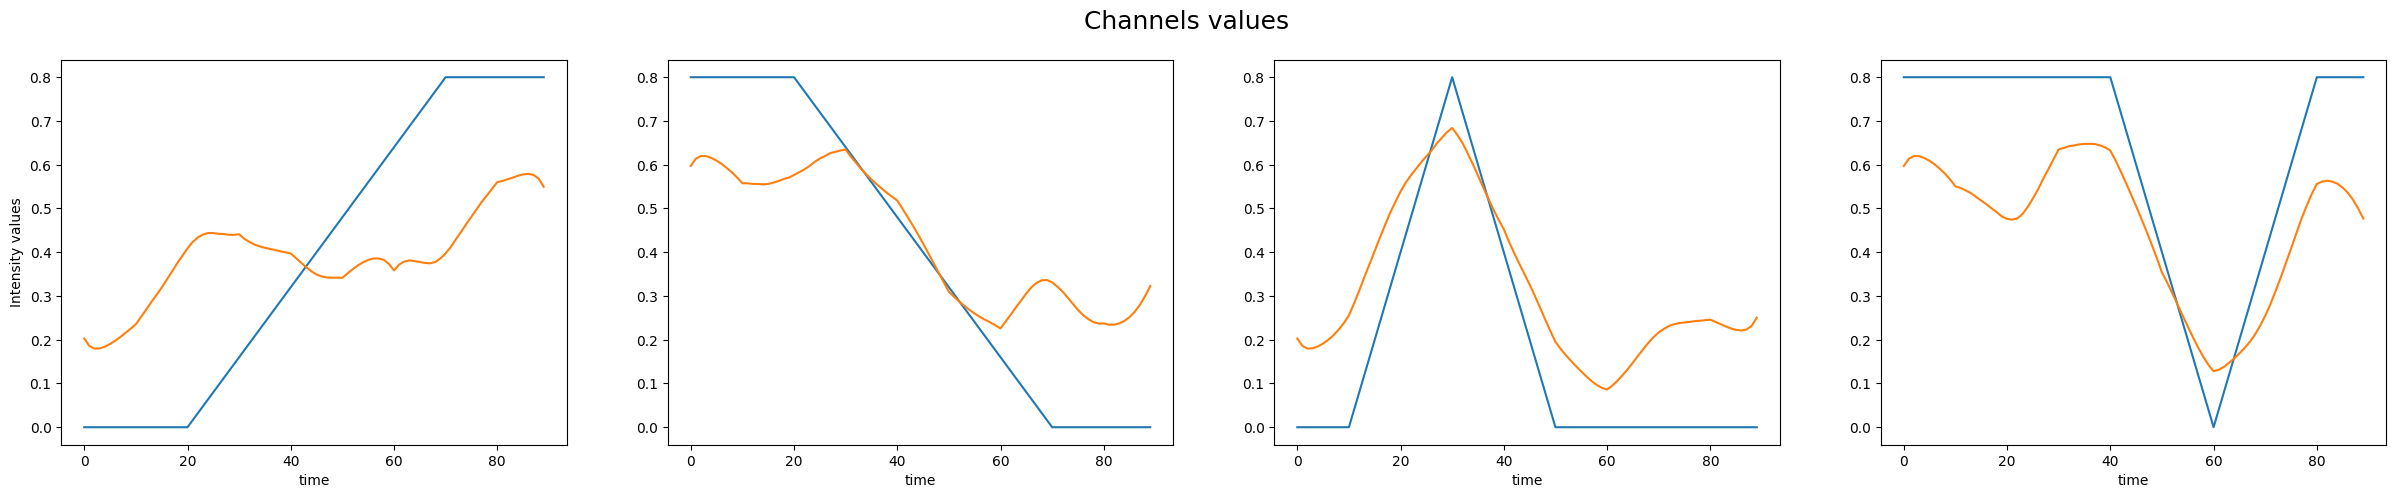

iteration: 20,	 sino rsme: 0.02649329217302046,	 objects rsme: 0.08626615740524952
iteration: 30,	 sino rsme: 0.019499118674272106,	 objects rsme: 0.0709201376214365
iteration: 40,	 sino rsme: 0.015889492610132783,	 objects rsme: 0.06097405323693537
iteration: 50,	 sino rsme: 0.013915492199656524,	 objects rsme: 0.05398324437069588


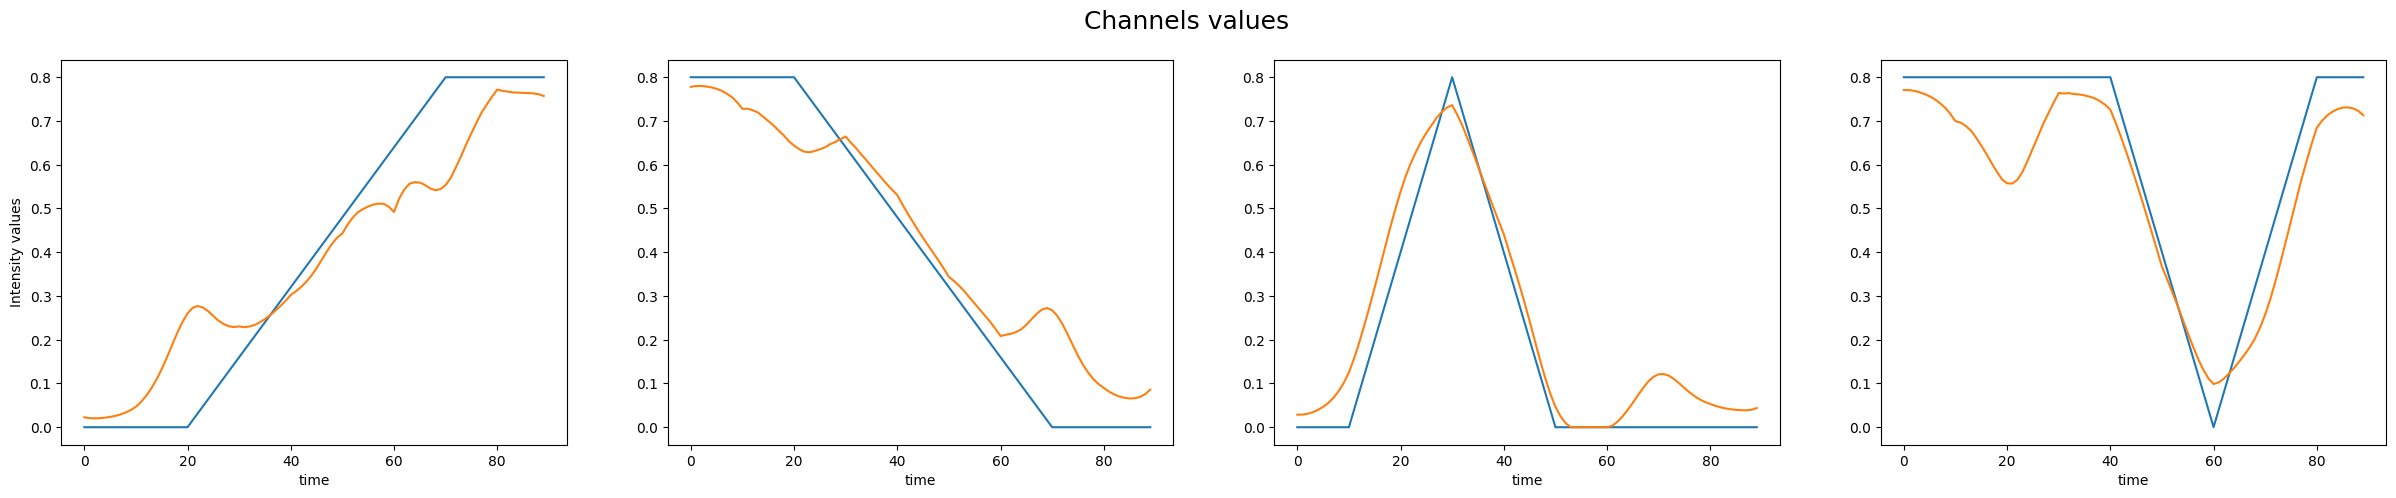

iteration: 60,	 sino rsme: 0.012732923444192747,	 objects rsme: 0.04879346260512841
iteration: 70,	 sino rsme: 0.011965999014347306,	 objects rsme: 0.04483698679985297
iteration: 80,	 sino rsme: 0.011429905034243357,	 objects rsme: 0.041787457051539696
iteration: 90,	 sino rsme: 0.011032927267506291,	 objects rsme: 0.039428514295827936
iteration: 100,	 sino rsme: 0.010734863194057764,	 objects rsme: 0.03761137028862498


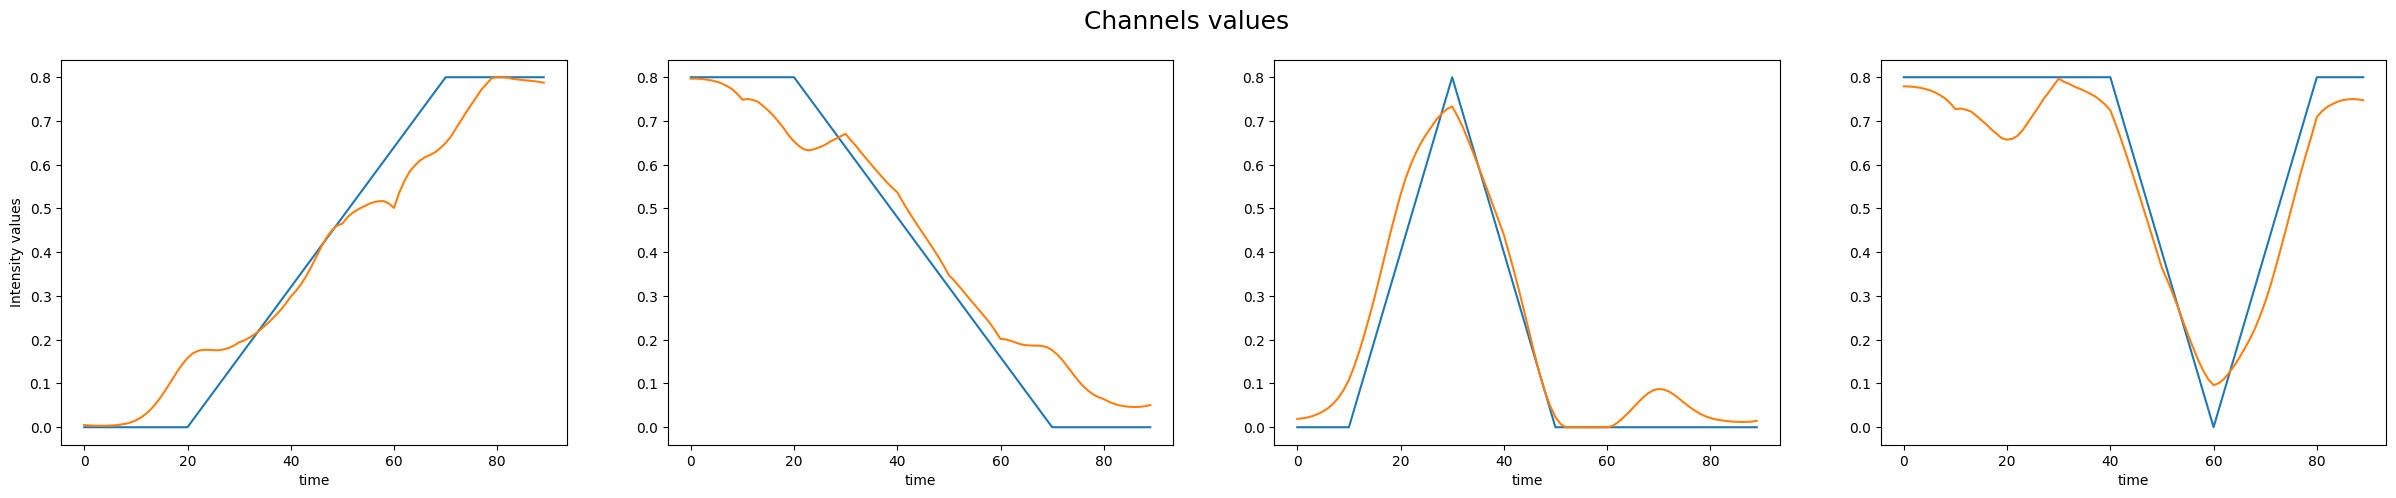

iteration: 110,	 sino rsme: 0.010508242087136549,	 objects rsme: 0.03621786685123482
iteration: 120,	 sino rsme: 0.01033316593588817,	 objects rsme: 0.03515189114500081
iteration: 130,	 sino rsme: 0.010199453527472566,	 objects rsme: 0.034341080508986536


full_sino_rrmse diff reached 0.001 at 136 iteration
0.010144910237616852, 0.010134850236159119, diff: 1.0060001457732476e-05


loop break at 136 iteration due to full_sino_rrmse_threshold_reached


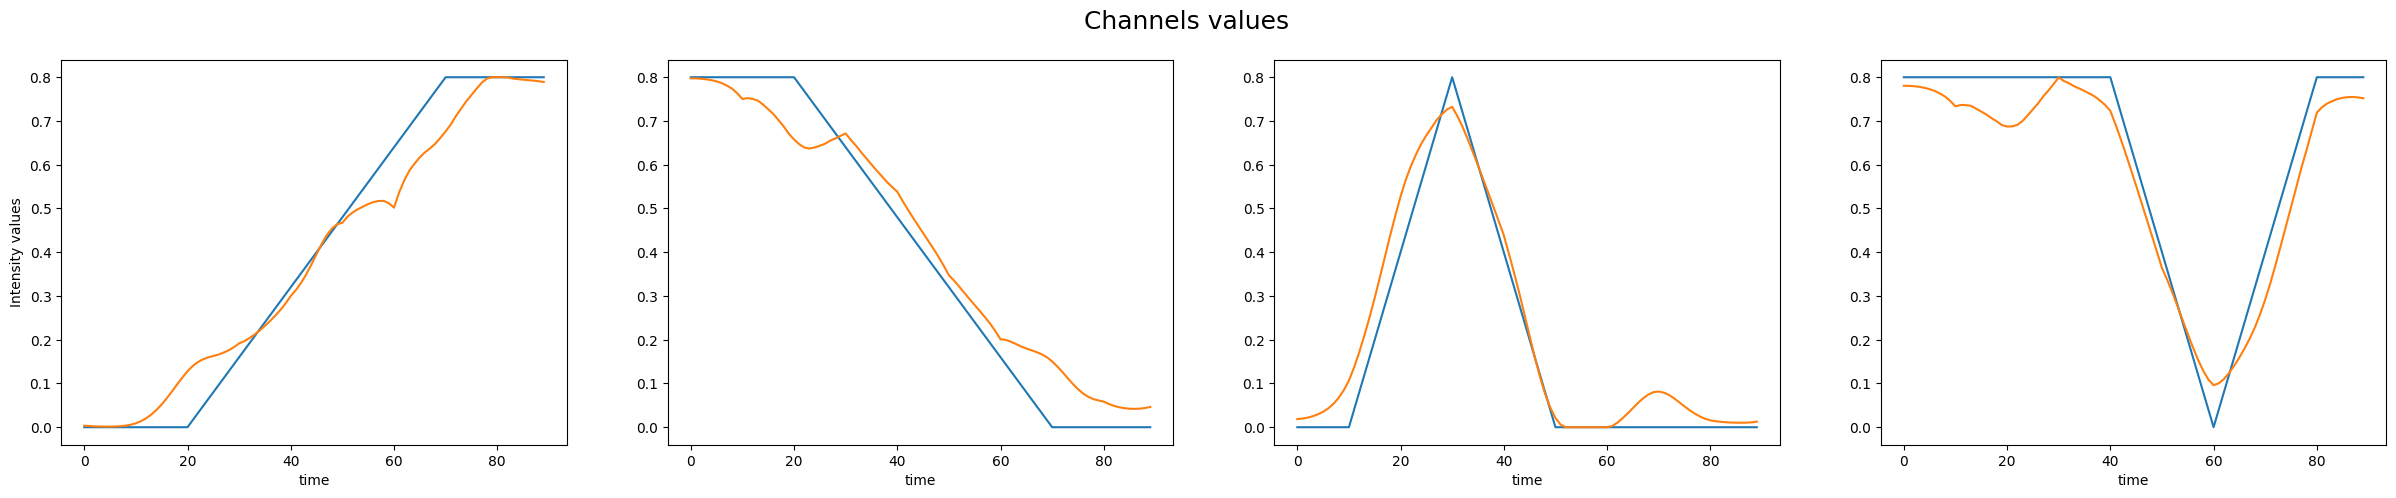

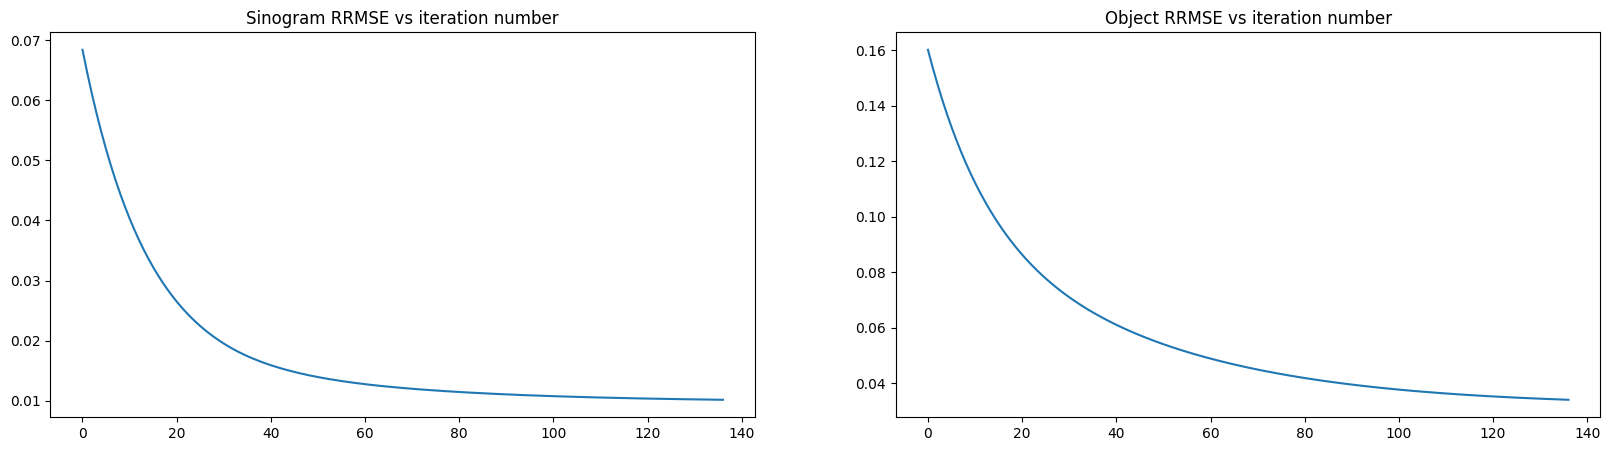

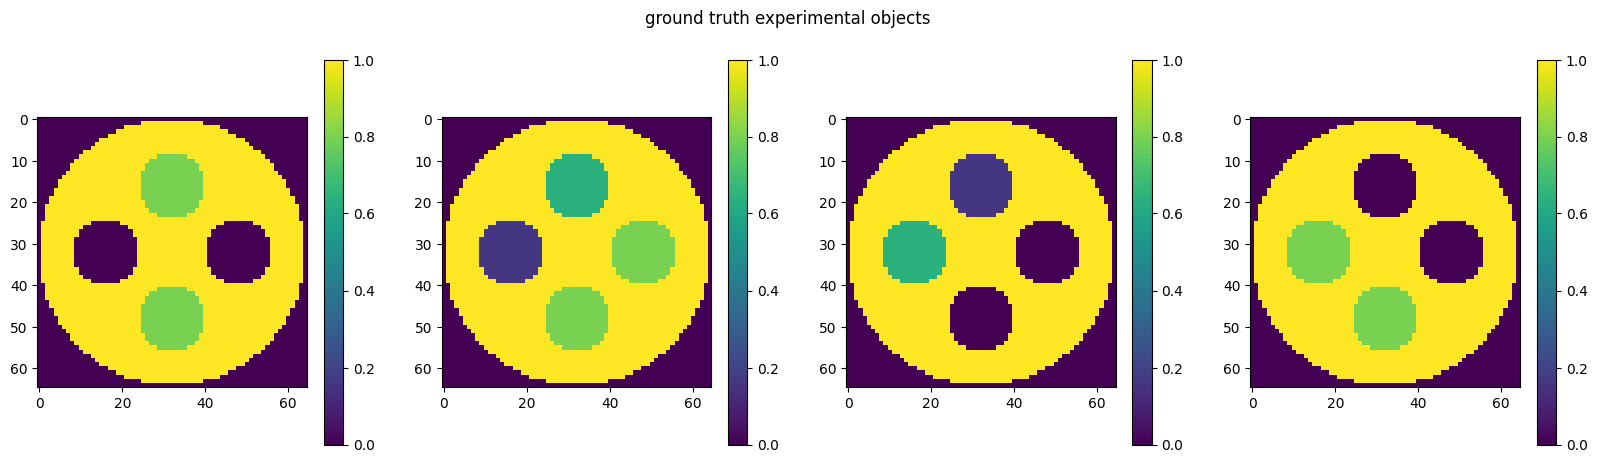

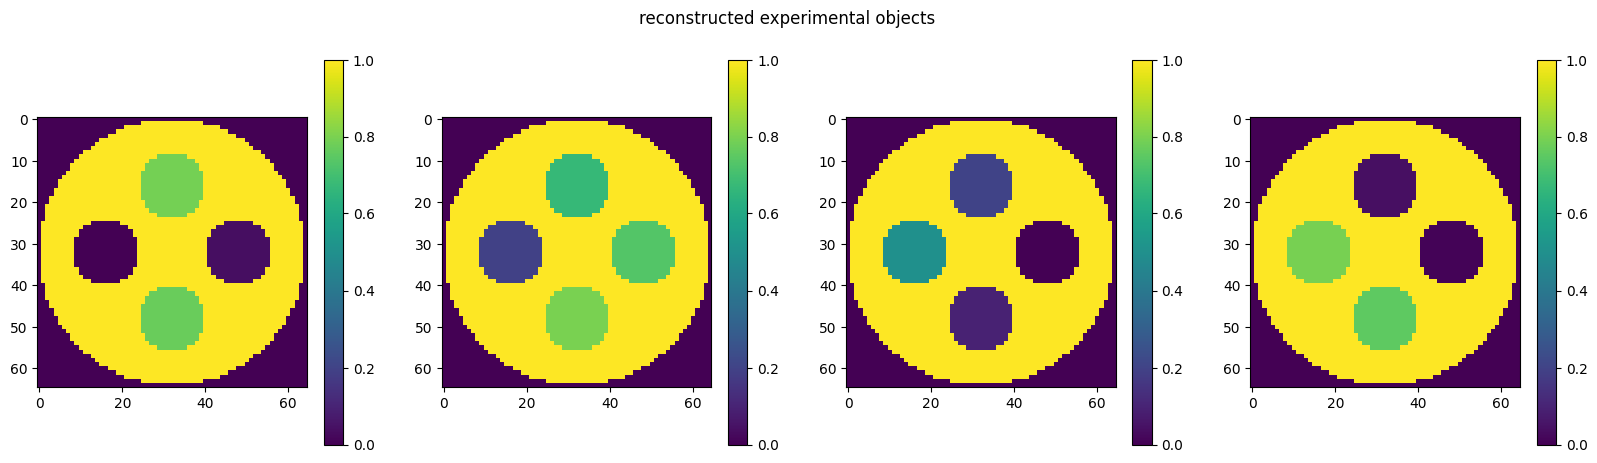

136 iterations takes 104.11960506439209 seconds
final sino rrmse: 0.010134850236159119,	 objects rrmse: 0.033951742478404774
final dyn sino rrmse: 0.06083712302468859,	 dyn objects rrmse: 0.12154144480632917




In [9]:
phantom_data = _fn.create_phantom_objects(number_of_time_points, 4)

_ = _fn.calc_2sts_4dct(*phantom_data[:-1], number_of_time_points, alg_type='new', show_info=True, iteration_stop_diff = 0.001)

### Old algorithm with "min-sort", 4-channel "regular" object, iteration_stop_diff = 0.001

In [10]:
_ = _fn.calc_2sts_4dct(*phantom_data[:-1], number_of_time_points, alg_type='old_min_sort', show_info=False, iteration_stop_diff = 0.001)

36 iterations takes 25.958184957504272 seconds
final sino rrmse: 0.053250668794467396,	 objects rrmse: 0.13425574022803088
final dyn sino rrmse: 0.3196512442816028,	 dyn objects rrmse: 0.480612641640912




### Old algorithm with "no-sort", 4-channel "regular" object, iteration_stop_diff = 0.001

In [11]:
_ = _fn.calc_2sts_4dct(*phantom_data[:-1], number_of_time_points, alg_type='old_no_sort', show_info=False, iteration_stop_diff = 0.001)

335 iterations takes 235.6831338405609 seconds
final sino rrmse: 0.010320883982817504,	 objects rrmse: 0.05658332487534212
final dyn sino rrmse: 0.061953839864945404,	 dyn objects rrmse: 0.20255864810677351




### Old algorithm with median filter, 4-channel "regular" object, iteration_stop_diff = 0.001

In [12]:
_ = _fn.calc_2sts_4dct(*phantom_data[:-1], number_of_time_points, alg_type='old_median', show_info=False, iteration_stop_diff = 0.001)

333 iterations takes 238.97110223770142 seconds
final sino rrmse: 0.010392336119377458,	 objects rrmse: 0.05460855416642609
final dyn sino rrmse: 0.062382750240627706,	 dyn objects rrmse: 0.19548930592866476




### Old algorithm with gaussian filter, 4-channel "regular" object, iteration_stop_diff = 0.001

In [13]:
_ = _fn.calc_2sts_4dct(*phantom_data[:-1], number_of_time_points, alg_type='old_gauss_filter', show_info=False, iteration_stop_diff = 0.001)

248 iterations takes 175.33776092529297 seconds
final sino rrmse: 0.018848527326583257,	 objects rrmse: 0.05198386214148035
final dyn sino rrmse: 0.11314327780694668,	 dyn objects rrmse: 0.18609335633678553




### New algorithm with 4-channel "sparse" object, iteration_stop_diff = 0.001

In [14]:
phantom_data = _fn.create_phantom_objects(number_of_time_points, 4, _ch_type='sparse')

_ = _fn.calc_2sts_4dct(*phantom_data[:-1], number_of_time_points, alg_type='new', show_info=False, iteration_stop_diff = 0.001)

135 iterations takes 101.09945487976074 seconds
final sino rrmse: 0.009119465158279277,	 objects rrmse: 0.028114406735147444
final dyn sino rrmse: 0.05643071048263621,	 dyn objects rrmse: 0.10064477888391321




### New algorithm with 4-channel "tight" object, iteration_stop_diff = 0.001

In [15]:
phantom_data = _fn.create_phantom_objects(number_of_time_points, 4, _ch_type='tight')

_ = _fn.calc_2sts_4dct(*phantom_data[:-1], number_of_time_points, alg_type='new', show_info=False, iteration_stop_diff = 0.001)

116 iterations takes 88.19427728652954 seconds
final sino rrmse: 0.0145827619081744,	 objects rrmse: 0.06427845977653548
final dyn sino rrmse: 0.08773622214647865,	 dyn objects rrmse: 0.23010591801392302




### New algorithm with 8-channel object, iteration_stop_diff = 0.001

In [16]:
phantom_data = _fn.create_phantom_objects(number_of_time_points, 8)

_ = _fn.calc_2sts_4dct(*phantom_data[:-1], number_of_time_points, alg_type='new', show_info=False, iteration_stop_diff = 0.001)

103 iterations takes 78.86226296424866 seconds
final sino rrmse: 0.005792468398356873,	 objects rrmse: 0.02100611347591489
final dyn sino rrmse: 0.08827489954968368,	 dyn objects rrmse: 0.12232161327719686




# **Run algorithm on bulk of objects with random positions of channels**

### 1000 number of tests may be too long, so you can set a less value, 100 or 10

In [45]:
# --- 65 pix ---

# k = 2

# ch_radius = 4
# number_of_ch = 8
# max_gap = 10

# ch_radius = 2
# number_of_ch = 16
# max_gap = 10

# ch_radius = 1
# number_of_ch = 32
# max_gap = 8


# --- 129 pix ---

k = 4

ch_radius = 2
number_of_ch = 32
max_gap = 15

# ch_radius = 4
# number_of_ch = 16
# max_gap = 20

# ch_radius = 8
# number_of_ch = 8
# max_gap = 22

size = 32 * k + 1

blank_object = _fn.create_blank_object(size)

n_of_iterations = np.array([], dtype='int')

sino_rrmse_array = np.array([])
dyn_sino_rrmse_array = np.array([])

obj_rrmse_array = np.array([])
dyn_obj_rrmse_array = np.array([])

channels_dist_mean = np.array([])
channels_dist_median = np.array([])
channels_dist_std = np.array([])

gap_array = np.array([], dtype='int')


iteration_stop_diff = 0.001

# number_of_tests = 1000
number_of_tests = 100

for ii in np.arange(number_of_tests):

    gap = np.random.choice(max_gap + 1)

    print(f'iteration {ii}, gap {gap}')
    empty_object, mask_object, channels_pixels, channels_stats = _fn.generate_random_channels_with_exact_gap(blank_object, 
                                                                                                             ch_radius, 
                                                                                                             number_of_ch, 
                                                                                                             gap=gap)
    if len(channels_pixels) != number_of_ch:
        continue
    else:
        phantom_data = _fn.create_random_phantom_objects(number_of_time_points, 
                                                         empty_object, 
                                                         mask_object, 
                                                         channels_pixels, 
                                                         size)
        result = _fn.calc_2sts_4dct(empty_object, 
                                    mask_object, 
                                    *phantom_data[:-1], 
                                    number_of_time_points, 
                                    alg_type='new', 
                                    show_info=False, 
                                    iteration_stop_diff=iteration_stop_diff)
        
        channels_dist_mean = np.append(channels_dist_mean, channels_stats['mean'])
        channels_dist_median = np.append(channels_dist_median, channels_stats['median'])
        
        n_of_iterations = np.append(n_of_iterations, result['iterations'])
        
        sino_rrmse_array = np.append(sino_rrmse_array, result['sino_rrmse'][-1])
        dyn_sino_rrmse_array = np.append(dyn_sino_rrmse_array, result['dyn_sino_rrmse'])
        
        obj_rrmse_array = np.append(obj_rrmse_array, result['obj_rrmse'][-1])
        dyn_obj_rrmse_array = np.append(dyn_obj_rrmse_array, result['dyn_obj_rrmse'])
        
        gap_array = np.append(gap_array, gap)

iteration 0, gap 6
49 iterations takes 105.5101900100708 seconds
final sino rrmse: 0.002915211500317359,	 objects rrmse: 0.022799296865180882
final dyn sino rrmse: 0.17530142515397026,	 dyn objects rrmse: 0.2846442797693495


iteration 1, gap 13
68 iterations takes 146.3361370563507 seconds
final sino rrmse: 0.002226851686652209,	 objects rrmse: 0.015832131424893366
final dyn sino rrmse: 0.14211116741073662,	 dyn objects rrmse: 0.19084497589382282


iteration 2, gap 4
44 iterations takes 95.27748799324036 seconds
final sino rrmse: 0.002841798144814712,	 objects rrmse: 0.024636626648919892
final dyn sino rrmse: 0.17179645774717484,	 dyn objects rrmse: 0.3212626295075815


iteration 3, gap 10
58 iterations takes 125.26304578781128 seconds
final sino rrmse: 0.0027618364958480208,	 objects rrmse: 0.018705955340605297
final dyn sino rrmse: 0.17774065254867888,	 dyn objects rrmse: 0.23123960574584626


iteration 4, gap 0
14 iterations takes 32.074303150177 seconds
final sino rrmse: 0.0044806

### save collected data to file

In [58]:
data_to_save = np.stack((
    channels_dist_mean, 
    channels_dist_median, 
    n_of_iterations, 
    sino_rrmse_array, 
    obj_rrmse_array, 
    gap_array,
    dyn_sino_rrmse_array, 
    dyn_obj_rrmse_array, 
))

with open('bulk_data.npy', 'wb') as f:
    np.save(f, data_to_save)

### load collected data from file (use file with 1000 number of tests)

In [111]:
# bulk_data_file = 'bulk_data_8_8_1000.npy'
# bulk_data_file = 'bulk_data_16_4_1000.npy'
bulk_data_file = 'bulk_data_32_2_1000.npy'

with open(bulk_data_file, 'rb') as f:
    (channels_dist_mean, 
    channels_dist_median, 
    n_of_iterations, 
    sino_rrmse_array, 
    obj_rrmse_array, 
    gap_array,
    dyn_sino_rrmse_array, 
    dyn_obj_rrmse_array) = np.load(f)

is_nan_idx = np.isnan(sino_rrmse_array)
print(is_nan_idx.sum())

if is_nan_idx.sum() > 0:
    channels_dist_mean = channels_dist_mean[~is_nan_idx]
    channels_dist_median = channels_dist_median[~is_nan_idx]
    n_of_iterations = n_of_iterations[~is_nan_idx]
    sino_rrmse_array = sino_rrmse_array[~is_nan_idx]
    obj_rrmse_array = obj_rrmse_array[~is_nan_idx]
    gap_array = gap_array[~is_nan_idx]
    dyn_sino_rrmse_array = dyn_sino_rrmse_array[~is_nan_idx]
    dyn_obj_rrmse_array = dyn_obj_rrmse_array[~is_nan_idx]

0


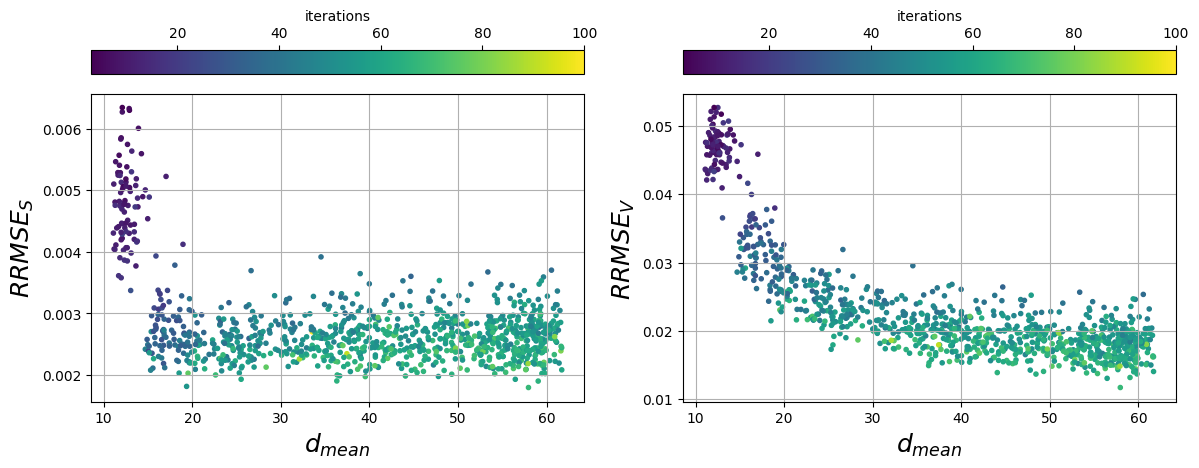

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
im0 = ax[0].scatter(channels_dist_mean, sino_rrmse_array, marker='.', c=n_of_iterations)
im1 = ax[1].scatter(channels_dist_mean, obj_rrmse_array, marker='.', c=n_of_iterations)
ax[0].set_xlabel('$d_{mean}$', fontsize=18)
ax[1].set_xlabel('$d_{mean}$', fontsize=18)
ax[0].set_ylabel('$RRMSE_S$', fontsize=18)
ax[1].set_ylabel('$RRMSE_V$', fontsize=18)
fig.colorbar(im0, ax=ax[0], location='top', label='iterations')
fig.colorbar(im1, ax=ax[1], location='top', label='iterations')
ax[0].grid()
ax[1].grid()

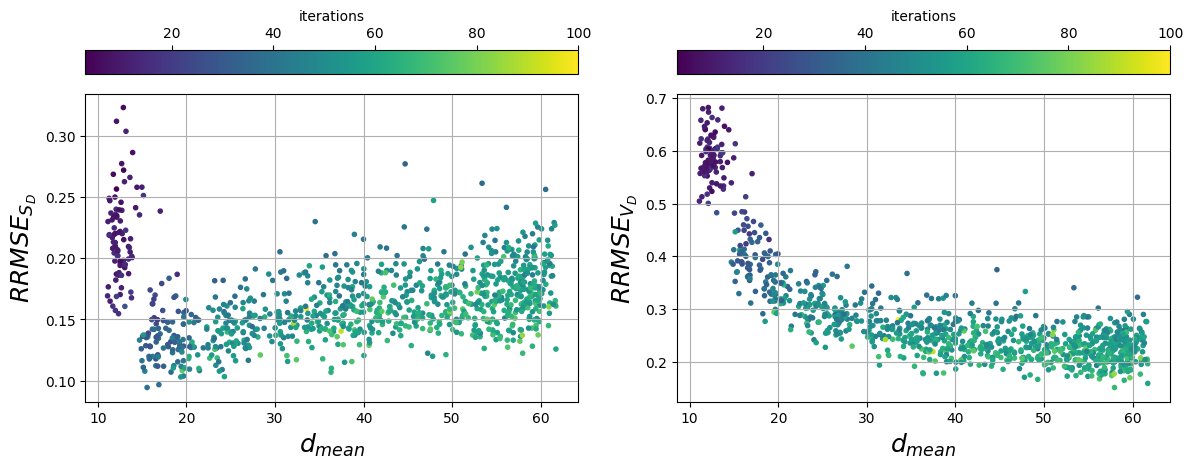

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
im0 = ax[0].scatter(channels_dist_mean, dyn_sino_rrmse_array, marker='.', c=n_of_iterations)
im1 = ax[1].scatter(channels_dist_mean, dyn_obj_rrmse_array, marker='.', c=n_of_iterations)
ax[0].set_xlabel('$d_{mean}$', fontsize=18)
ax[1].set_xlabel('$d_{mean}$', fontsize=18)
ax[0].set_ylabel('$RRMSE_{S_D}$', fontsize=18)
ax[1].set_ylabel('$RRMSE_{V_D}$', fontsize=18)
fig.colorbar(im0, ax=ax[0], location='top', label='iterations')
fig.colorbar(im1, ax=ax[1], location='top', label='iterations')
ax[0].grid()
ax[1].grid()

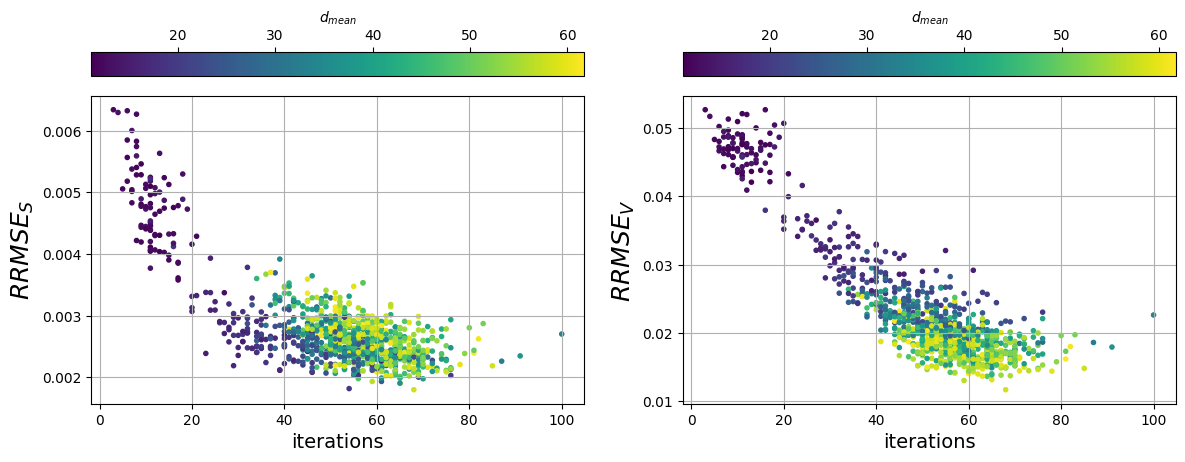

In [114]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
im0 = ax[0].scatter(n_of_iterations, sino_rrmse_array, marker='.', c=channels_dist_mean)
im1 = ax[1].scatter(n_of_iterations, obj_rrmse_array, marker='.', c=channels_dist_mean)
ax[0].set_xlabel('iterations', fontsize=14)
ax[1].set_xlabel('iterations', fontsize=14)
ax[0].set_ylabel('$RRMSE_S$', fontsize=18)
ax[1].set_ylabel('$RRMSE_V$', fontsize=18)
fig.colorbar(im0, ax=ax[0], location='top', label='$d_{mean}$')
fig.colorbar(im1, ax=ax[1], location='top', label='$d_{mean}$')
ax[0].grid()
ax[1].grid()

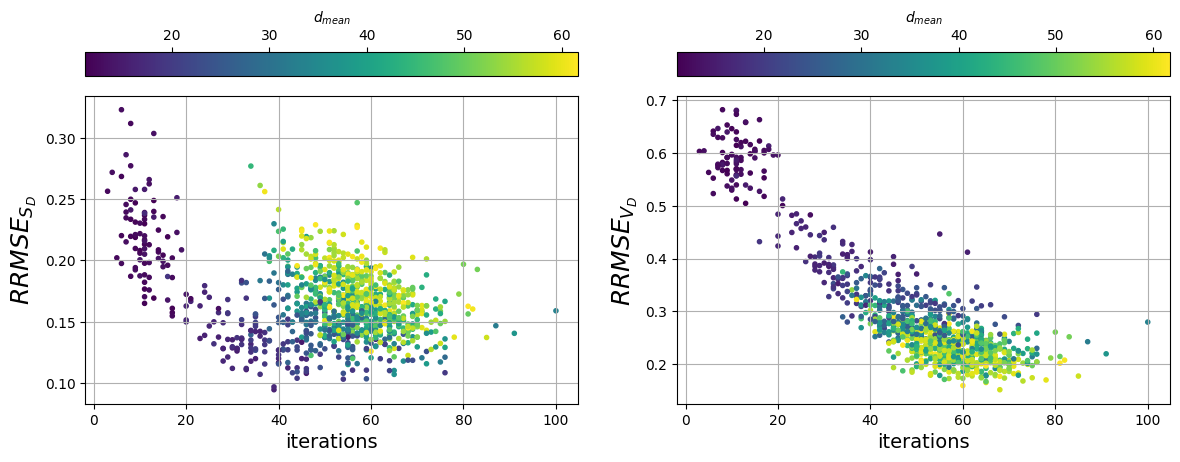

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
im0 = ax[0].scatter(n_of_iterations, dyn_sino_rrmse_array, marker='.', c=channels_dist_mean)
im1 = ax[1].scatter(n_of_iterations, dyn_obj_rrmse_array, marker='.', c=channels_dist_mean)
ax[0].set_xlabel('iterations', fontsize=14)
ax[1].set_xlabel('iterations', fontsize=14)
ax[0].set_ylabel('$RRMSE_{S_D}$', fontsize=18)
ax[1].set_ylabel('$RRMSE_{V_D}$', fontsize=18)
fig.colorbar(im0, ax=ax[0], location='top', label='$d_{mean}$')
fig.colorbar(im1, ax=ax[1], location='top', label='$d_{mean}$')
ax[0].grid()
ax[1].grid()

0.851630610184036

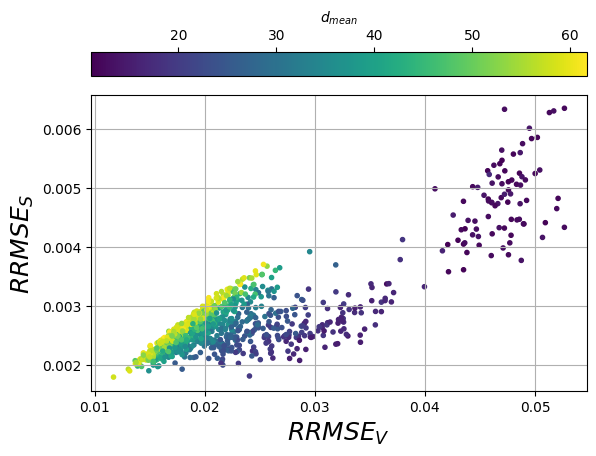

In [116]:
plt.scatter(obj_rrmse_array, sino_rrmse_array, marker='.', c=channels_dist_mean)
plt.xlabel('$RRMSE_V$', fontsize=18)
plt.ylabel('$RRMSE_S$', fontsize=18)
plt.colorbar(location='top', label='$d_{mean}$')
plt.grid()

np.corrcoef(obj_rrmse_array, sino_rrmse_array)[0, 1]

0.44671077652333835

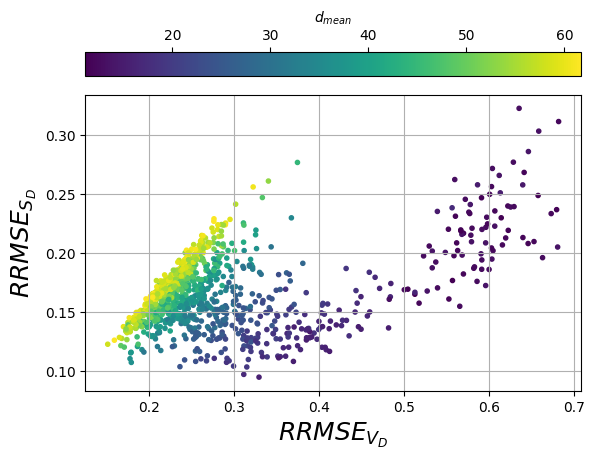

In [117]:
plt.scatter(dyn_obj_rrmse_array, dyn_sino_rrmse_array, marker='.', c=channels_dist_mean)
plt.xlabel('$RRMSE_{V_D}$', fontsize=18)
plt.ylabel('$RRMSE_{S_D}$', fontsize=18)
plt.colorbar(location='top', label='$d_{mean}$')
plt.grid()

np.corrcoef(dyn_obj_rrmse_array, dyn_sino_rrmse_array)[0, 1]